<a href="https://colab.research.google.com/github/hurileborjigin/pytorch_notes/blob/main/CNN_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN Implementation

## Basics

In [209]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [210]:
# Convert mnist image file to tensor of 4 Dimensions(# of images, height, width, color channel)
transform = transforms.ToTensor()


In [211]:
# Train data
train_data = datasets.MNIST(root='/cnn_data', train=True, download=True, transform=transform)

In [212]:
# Test data
test_data = datasets.MNIST(root='/cnn_data', train=False, download=True, transform=transform)

In [213]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [214]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: /cnn_data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [215]:
ls /cnn_data/MNIST/raw

t10k-images-idx3-ubyte     t10k-labels-idx1-ubyte.gz   train-labels-idx1-ubyte
t10k-images-idx3-ubyte.gz  train-images-idx3-ubyte     train-labels-idx1-ubyte.gz
t10k-labels-idx1-ubyte     train-images-idx3-ubyte.gz


In [216]:
# Create a small batch size for images
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [217]:
# Define our CNN model
# Describe Conv layer and what it's doing
# 2 conv layers
conv1 = nn.Conv2d(1, 6, 3, 1)
# (in_channels: int, out_channels: int, kernel_size: _size_2_t, stride: _size_2_t = 1, padding: _size_2_t | str = 0, dilation: _size_2_t = 1, groups: int = 1, bias: bool = True, padding_mode: str = "zeros", device: Any | None = None, dtype: Any | None = None) -> None
conv2 = nn.Conv2d(6, 16, 3, 1)


# Grab 1 mnsit record/image
for i, (X_train, y_train) in enumerate(train_data):
  break

In [218]:
X_train.shape

torch.Size([1, 28, 28])

In [219]:
x = X_train.view(1, 1, 28, 28)

In [220]:
# Perform our first conv
x = F.relu(conv1(x))  # Define Rectified Linear Unit as activation function

In [221]:
x.shape
# 1 single image
# 6 filters
# 26 X 26 is the image size after one conv layer without padding

torch.Size([1, 6, 26, 26])

In [222]:
# Pass thru the pooling layer
x = F.max_pool2d(x, 2, 2) # Kernal of 2 X 2 and stride of 2

In [223]:
x.shape

torch.Size([1, 6, 13, 13])

In [224]:
# Second conv layer
x = F.relu(conv2(x))

In [225]:
x.shape

torch.Size([1, 16, 11, 11])

In [226]:
x = F.max_pool2d(x, 2, 2)

In [227]:
x.shape

torch.Size([1, 16, 5, 5])

In [228]:
((28 - 2) / 2 - 2) / 2

5.5

## Model Class

In [229]:
# Model class
class ConvNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 6, 3, 1)
    self.conv2 = nn.Conv2d(6, 16, 3, 1)
    # Fully connected layer
    self.fc1 = nn.Linear(5 * 5 * 16, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, X):
    # First pass
    X = F.relu(conv1(X))
    X = F.max_pool2d(X, 2, 2)
    # Second pass
    X = F.relu(conv2(X))
    X = F.max_pool2d(X, 2, 2)

    # Re-View to flatten it out
    X = X.view(-1, 16 * 5 * 5) # Negative one so that we can vary the batch size

    # Fully connected layers
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)

    return F.log_softmax(X, dim=1)



In [230]:
# Create an instance of our model
torch.manual_seed(41)

model = ConvNN()
model

ConvNN(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [231]:
# Loss function optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [232]:
import time
start_time = time.time()

# Create variables to track things
epochs = 5
train_losses = []

test_losses = []

train_correct = []

test_correct = []



# Create for loops for epochs
for i in range(epochs):
  trn_corr = 0
  ts_corr = 0

  # Train
  for b, (X_train, y_train) in enumerate(train_loader):
    b += 1
    y_pred = model(X_train) # Get predicted values from the training dataset(Not flattened)
    loss = criterion(y_pred, y_train)

    predicted = torch.max(y_pred.data, 1)[1] # add up the number of correct predictions, indexed off the first point

    batch_corr  = (predicted == y_train).sum() # How many correct we got from this batch

    trn_corr += batch_corr # Kepp track as we go along in training

    # update parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    # Print results
    if b%600 == 0:
      print(f'Epoch: {i}, Batch: {b}, Loss: {loss.item()}')

  train_losses.append(loss)
  train_correct.append(trn_corr)

  # Test
  with torch.no_grad():
    for b, (X_test, y_test) in enumerate(test_loader):
      y_val = model(X_test)
      predicted = torch.max(y_val.data, 1)[1]
      ts_corr += (predicted == y_test).sum()

  loss = criterion(y_val, y_test)
  test_losses.append(loss)
  test_correct.append(ts_corr)


current_time = time.time()
total_time = current_time - start_time
print(f'Training took: {total_time/60} mins')

Epoch: 0, Batch: 600, Loss: 0.8005474209785461
Epoch: 0, Batch: 1200, Loss: 0.5261454582214355
Epoch: 0, Batch: 1800, Loss: 1.2068359851837158
Epoch: 0, Batch: 2400, Loss: 0.28653863072395325
Epoch: 0, Batch: 3000, Loss: 0.6326301097869873
Epoch: 0, Batch: 3600, Loss: 0.5581604838371277
Epoch: 0, Batch: 4200, Loss: 0.25138580799102783
Epoch: 0, Batch: 4800, Loss: 0.19312916696071625
Epoch: 0, Batch: 5400, Loss: 0.04995734617114067
Epoch: 0, Batch: 6000, Loss: 0.04287618026137352
Epoch: 1, Batch: 600, Loss: 0.022873438894748688
Epoch: 1, Batch: 1200, Loss: 0.14631441235542297
Epoch: 1, Batch: 1800, Loss: 0.08650842308998108
Epoch: 1, Batch: 2400, Loss: 0.06168324872851372
Epoch: 1, Batch: 3000, Loss: 0.3931301534175873
Epoch: 1, Batch: 3600, Loss: 0.2552063465118408
Epoch: 1, Batch: 4200, Loss: 0.12678317725658417
Epoch: 1, Batch: 4800, Loss: 0.06892555207014084
Epoch: 1, Batch: 5400, Loss: 0.08071465790271759
Epoch: 1, Batch: 6000, Loss: 0.3583010137081146
Epoch: 2, Batch: 600, Loss: 0

In [233]:
train_losses

[tensor(0.0429, grad_fn=<NllLossBackward0>),
 tensor(0.3583, grad_fn=<NllLossBackward0>),
 tensor(0.5810, grad_fn=<NllLossBackward0>),
 tensor(0.1961, grad_fn=<NllLossBackward0>),
 tensor(0.0058, grad_fn=<NllLossBackward0>)]

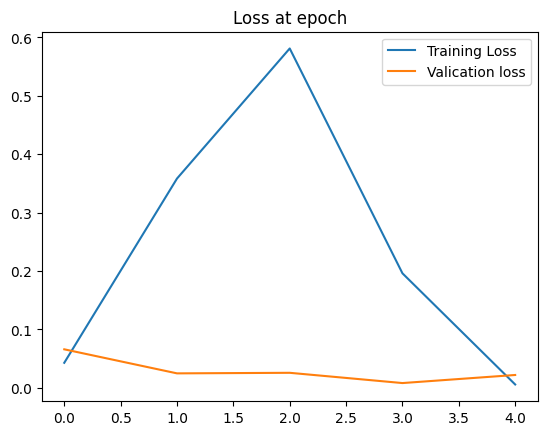

In [234]:
# Graph the loss at  epoch

train_losses = [tl.item() for tl in train_losses]

plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Valication loss')
plt.title('Loss at epoch')
plt.legend()

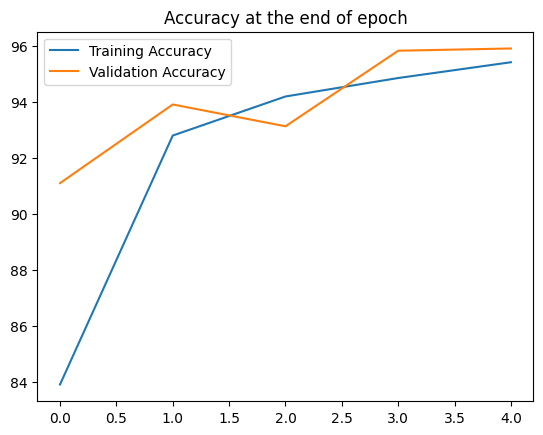

In [235]:
# Graph the accuracy
plt.plot([t/600 for t in train_correct], label='Training Accuracy')
plt.plot([t/100 for t in test_correct], label='Validation Accuracy')

plt.title("Accuracy at the end of epoch")
plt.legend()

In [236]:
test_load_everything = DataLoader(test_data, batch_size=10000, shuffle=False)

In [237]:
with torch.no_grad():
  correct = 0
  for X_test, y_test in test_load_everything:
    y_val = model(X_test)
    predicted = torch.max(y_val.data, 1)[1]
    correct += (predicted == y_test).sum()


In [238]:
# correct count
correct.item()/len(test_data)

0.9591

In [252]:
test_data[6666] # Tensor with an image and a label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [253]:
test_data[6666][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [254]:
test_data[6666][0].reshape(28, 28)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

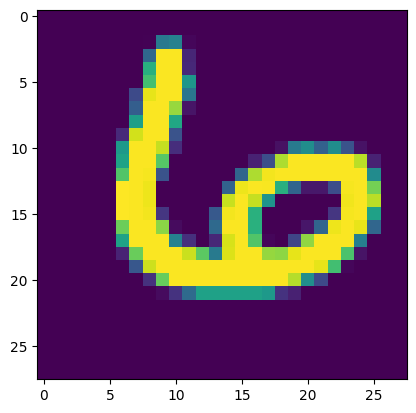

In [266]:
plt.imshow(test_data[665][0].reshape(28, 28))

In [267]:
new_img = test_data[665][0].reshape(28, 28)
# Pass the img to model
model.eval()

ConvNN(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [268]:
with torch.no_grad():
  new_prediction = model(new_img.view(1, 1, 28, 28)) # 1 batch 1 color channel and 28 X 28 image


In [269]:
# Check the new prediction
torch.max(new_prediction.data, 1)[1].item()

6

In [270]:
new_prediction.argmax()

tensor(6)